In [1]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
sys.path.insert(1, str(Path.cwd().parent))
str(Path.cwd().parent)

'c:\\Users\\Joaquín Amat\\Documents\\GitHub\\skforecast'

In [2]:
#!pip uninstall -y skforecast

In [3]:
# Libraries
# ==============================================================================
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import random_search_forecaster
from skforecast.model_selection import bayesian_search_forecaster
from sklearn.metrics import mean_squared_error
from skforecast.model_selection import backtesting_forecaster
import numpy as np

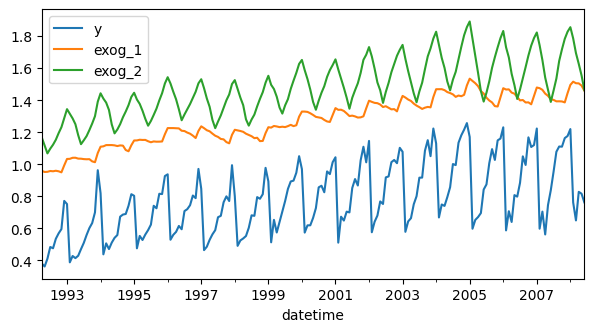

In [4]:
# Download data
# ==============================================================================
url = (
    'https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/'
    'data/h2o_exog.csv'
)
data = pd.read_csv(
            url, sep=',', header=0, names=['datetime', 'y', 'exog_1', 'exog_2']
       )

# Data preprocessing
# ==============================================================================
data['datetime'] = pd.to_datetime(data['datetime'], format='%Y-%m-%d')
data = data.set_index('datetime')
data = data.asfreq('MS')
data = data.sort_index()

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(7, 3.5))
data.plot(ax=ax);

In [5]:
end_train = '2001-01-01 23:59:00'
end_val = '2006-01-01 23:59:00'

In [6]:
# Grid search hyperparameters and lags
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = RandomForestRegressor(random_state=123),
                 lags      = 10, # Placeholder, the value will be overwritten
                 differentiation = 1
             )

# Lags used as predictors
lags_grid = [3, 10]

# Regressor hyperparameters
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [5, 10]
}

results_grid = grid_search_forecaster(
                   forecaster         = forecaster,
                   y                  = data.loc[:end_val, 'y'],
                   param_grid         = param_grid,
                   lags_grid          = lags_grid,
                   steps              = 12,
                   refit              = False,
                   metric             = 'mean_squared_error',
                   initial_train_size = len(data.loc[:end_train]),
                   fixed_train_size   = False,
                   return_best        = True,
                   n_jobs             = 1,
                   verbose            = False,
                   show_progress      = True
               )

Number of models compared: 8.


lags grid:   0%|          | 0/2 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10] 
  Parameters: {'max_depth': 10, 'n_estimators': 50}
  Backtesting metric: 0.13079961115323863



In [7]:
from skforecast.model_selection import backtesting_forecaster

forecaster = ForecasterAutoreg(
                 regressor = RandomForestRegressor(random_state=123),
                 lags      = 10, # Placeholder, the value will be overwritten
                 differentiation = 1
             )

metric, predictions = backtesting_forecaster(
                          forecaster            = forecaster,
                          y                     = data['y'],
                          steps                 = 10,
                          metric                = 'mean_squared_error',
                          initial_train_size    = len(data.loc[:end_train]),
                          fixed_train_size      = False,
                          gap                   = 0,
                          allow_incomplete_fold = True,
                          refit                 = True,
                          n_jobs                = 1,
                          verbose               = False,
                          show_progress         = True  
                      )

  0%|          | 0/9 [00:00<?, ?it/s]

In [8]:
data.isna().sum()

y         0
exog_1    0
exog_2    0
dtype: int64

In [9]:
def create_predictors(y):
    """
    Create first 10 lags of a time series.
    Calculate moving average with window 20.
    """

    lags = y[-1:-11:-1]     # window_size = 10
    mean = np.mean(y[-20:]) # window_size = 20
    predictors = np.hstack([lags, mean])

    return predictors


forecaster = ForecasterAutoregCustom(
                 regressor = RandomForestRegressor(random_state=123),
                 fun_predictors = create_predictors,
                 window_size=20,
                 differentiation = 1
             )

metric, predictions = backtesting_forecaster(
                          forecaster            = forecaster,
                          y                     = data['y'],
                          steps                 = 10,
                          metric                = 'mean_squared_error',
                          initial_train_size    = len(data.loc[:end_train]),
                          fixed_train_size      = False,
                          gap                   = 0,
                          allow_incomplete_fold = True,
                          refit                 = True,
                          n_jobs                = 1,
                          verbose               = False,
                          show_progress         = True  
                      )

  0%|          | 0/9 [00:00<?, ?it/s]

In [10]:
# Regressor hyperparameters
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [5, 10]
}

results_grid = grid_search_forecaster(
                   forecaster         = forecaster,
                   y                  = data.loc[:end_val, 'y'],
                   param_grid         = param_grid,
                   lags_grid          = lags_grid,
                   steps              = 12,
                   refit              = False,
                   metric             = 'mean_squared_error',
                   initial_train_size = len(data.loc[:end_train]),
                   fixed_train_size   = False,
                   return_best        = True,
                   n_jobs             = 1,
                   verbose            = False,
                   show_progress      = True
               )

Number of models compared: 4.


c:\Users\Joaquín Amat\Documents\GitHub\skforecast\skforecast\model_selection\model_selection.py:1140: IgnoredArgumentWarning: `lags_grid` ignored if forecaster is an instance of `ForecasterAutoregCustom`. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=IgnoredArgumentWarning)
  warnings.warn(


lags grid:   0%|          | 0/1 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: custom predictors 
  Parameters: {'max_depth': 10, 'n_estimators': 100}
  Backtesting metric: 0.06698460461030693



In [19]:
import re
import pytest
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.model_selection.model_selection import _evaluate_grid_hyperparameters

from tqdm import tqdm
from functools import partialmethod
tqdm.__init__ = partialmethod(tqdm.__init__, disable=True) # hide progress bar

# Fixtures
from skforecast.model_selection.tests.fixtures_model_selection import y

Number of models compared: 6.


lags grid:   0%|          | 0/2 [00:00<?, ?it/s]

params grid:   0%|          | 0/3 [00:00<?, ?it/s]

In [12]:
forecaster = ForecasterAutoreg(
                    regressor = Ridge(random_state=123),
                    lags      = 2, # Placeholder, the value will be overwritten
                    differentiation=1
                 )

steps = 3
n_validation = 12
y_train = y[:-n_validation]
lags_grid = [2, 4]
param_grid = [{'alpha': 0.01}, {'alpha': 0.1}, {'alpha': 1}]
idx = len(lags_grid)*len(param_grid)

results = _evaluate_grid_hyperparameters(
                        forecaster  = forecaster,
                        y           = y,
                        lags_grid   = lags_grid,
                        param_grid  = param_grid,
                        steps       = steps,
                        refit       = False,
                        metric      = 'mean_squared_error',
                        initial_train_size = len(y_train),
                        fixed_train_size   = False,
                        return_best = False,
                        verbose     = False
            ).reset_index(drop=True)
results

expected_results = pd.DataFrame({
            'lags'  :[[1, 2, 3, 4], [1, 2], [1, 2, 3, 4], [1, 2], [1, 2], [1, 2, 3, 4]],
            'params':[{'alpha': 1}, {'alpha': 1}, {'alpha': 0.1}, {'alpha': 0.1}, {'alpha': 0.01}, {'alpha': 0.01}],
            'mean_squared_error':np.array([0.09168123, 0.09300068, 0.09930084, 0.09960109, 0.10102995, 0.1012931]),                                                               
            'alpha' :np.array([1., 1., 0.1, 0.1, 0.01 , 0.01])
                                     },
            index=pd.RangeIndex(start=0, stop=idx, step=1)
                                   )

Number of models compared: 6.


lags grid:   0%|          | 0/2 [00:00<?, ?it/s]

params grid:   0%|          | 0/3 [00:00<?, ?it/s]

lags           params  mean_squared_error  alpha
5  [1, 2, 3, 4]     {'alpha': 1}            0.091681   1.00
2        [1, 2]     {'alpha': 1}            0.093001   1.00
4  [1, 2, 3, 4]   {'alpha': 0.1}            0.099301   0.10
1        [1, 2]   {'alpha': 0.1}            0.099601   0.10
0        [1, 2]  {'alpha': 0.01}            0.101030   0.01
3  [1, 2, 3, 4]  {'alpha': 0.01}            0.101293   0.01

In [18]:
expected_results

lags           params  mean_squared_error  alpha
0  [1, 2, 3, 4]     {'alpha': 1}            0.091681   1.00
1        [1, 2]     {'alpha': 1}            0.093001   1.00
2  [1, 2, 3, 4]   {'alpha': 0.1}            0.099301   0.10
3        [1, 2]   {'alpha': 0.1}            0.099601   0.10
4        [1, 2]  {'alpha': 0.01}            0.101030   0.01
5  [1, 2, 3, 4]  {'alpha': 0.01}            0.101293   0.01